# Vision Transformers

The code below has been modified from an existing implementation. It has been sourced from the following references.
- [ViT Blogpost by Francesco Zuppichini](https://towardsdatascience.com/implementing-visualttransformer-in-pytorch-184f9f16f632)
- [D2L Tutorial ](https://d2l.ai/chapter_attention-mechanisms-and-transformers/vision-transformer.html)
- [Brian Pulfer Medium Blogpost](https://medium.com/mlearning-ai/vision-transformers-from-scratch-pytorch-a-step-by-step-guide-96c3313c2e0c)
- [Lucidrains implementation Github ](https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/vit.py)
- [DeepFindr Video](https://www.youtube.com/watch?v=j3VNqtJUoz0&t=605s)

## Setup

In [2]:
pip list

Package                   Version
------------------------- --------------
anyio                     4.8.0
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
arrow                     1.3.0
asttokens                 3.0.0
async-lru                 2.0.4
attrs                     25.1.0
babel                     2.16.0
beautifulsoup4            4.12.3
bleach                    6.2.0
certifi                   2025.1.31
cffi                      1.17.1
charset-normalizer        3.4.1
comm                      0.2.2
contourpy                 1.3.1
cycler                    0.12.1
debugpy                   1.8.12
decorator                 5.1.1
defusedxml                0.7.1
einops                    0.8.1
executing                 2.2.0
fastjsonschema            2.21.1
filelock                  3.17.0
fonttools                 4.55.8
fqdn                      1.5.1
fsspec                    2024.12.0
h11                       0.14.0
httpcore                  1.0.7
httpx    

## Image Patching



100%|████████████████████████████████████████| 792M/792M [00:21<00:00, 36.8MB/s]
100%|██████████████████████████████████████| 19.2M/19.2M [00:01<00:00, 18.7MB/s]


Dataset OxfordIIITPet
    Number of datapoints: 3680
    Root location: .


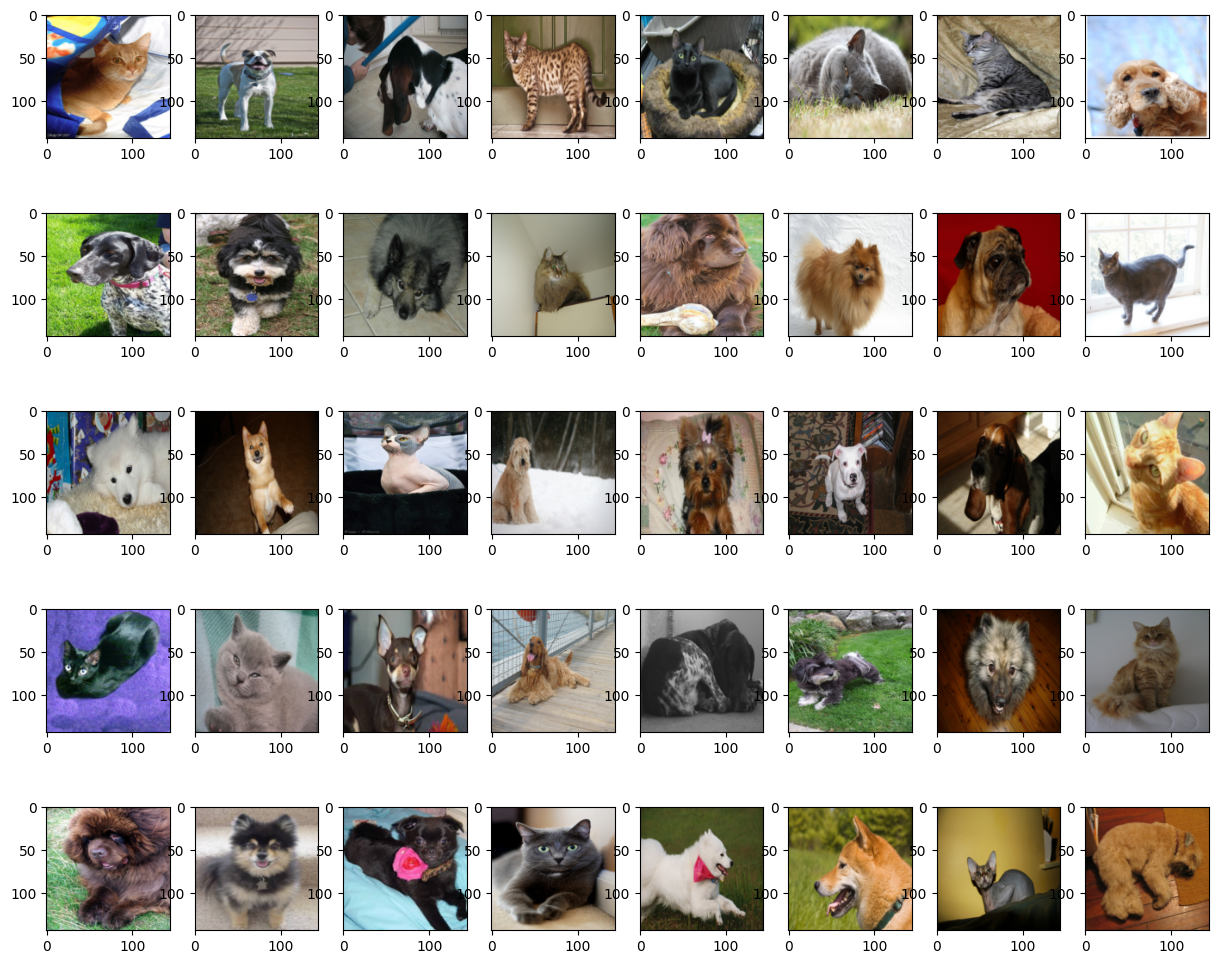

In [5]:
import torch
from torchvision.datasets import OxfordIIITPet
import matplotlib.pyplot as plt
from random import random
from torchvision.transforms import Resize, ToTensor
from torchvision.transforms.functional import to_pil_image

to_tensor = [Resize((144, 144)), ToTensor()]

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image = t(image)
        return image, target

def show_images(images, num_samples=40, cols=8):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15))
    idx = int(len(dataset) / num_samples)
    print(images)
    for i, img in enumerate(images):
        if i % idx == 0:
            plt.subplot(int(num_samples/cols) + 1, cols, int(i/idx) + 1)
            plt.imshow(to_pil_image(img[0]))

# 200 images for each pet
dataset = OxfordIIITPet(root=".", download=True, transforms=Compose(to_tensor))
show_images(dataset)

### Patch Images

In [6]:
from torch import nn
from einops.layers.torch import Rearrange
from torch import Tensor


class PatchEmbedding(nn.Module):
    def __init__(self, in_channels = 3, patch_size = 8, emb_size = 128):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # break-down the image in s1 x s2 patches and flat them
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
            nn.Linear(patch_size * patch_size * in_channels, emb_size)
        )

    def forward(self, x: Tensor) -> Tensor:
        x = self.projection(x)
        return x

# Run a quick test
sample_datapoint = torch.unsqueeze(dataset[0][0], 0)
print("Initial shape: ", sample_datapoint.shape)
embedding = PatchEmbedding()(sample_datapoint)
print("Patches shape: ", embedding.shape)

Initial shape:  torch.Size([1, 3, 144, 144])
Patches shape:  torch.Size([1, 324, 128])


## Model

In [7]:
from einops import rearrange

class Attention(nn.Module):
    def __init__(self, dim, n_heads, dropout):
        super().__init__()
        self.n_heads = n_heads
        self.att = torch.nn.MultiheadAttention(embed_dim=dim,
                                               num_heads=n_heads,
                                               dropout=dropout)
        self.q = torch.nn.Linear(dim, dim)
        self.k = torch.nn.Linear(dim, dim)
        self.v = torch.nn.Linear(dim, dim)

    def forward(self, x):
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)
        attn_output, attn_output_weights = self.att(x, x, x)
        return attn_output

In [8]:
Attention(dim=128, n_heads=4, dropout=0.)(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

In [9]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

In [10]:
norm = PreNorm(128, Attention(dim=128, n_heads=4, dropout=0.))
norm(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

In [11]:
class FeedForward(nn.Sequential):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
ff = FeedForward(dim=128, hidden_dim=256)
ff(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

In [12]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

In [13]:
residual_att = ResidualAdd(Attention(dim=128, n_heads=4, dropout=0.))
residual_att(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

Code henceforth is different from the original implementation. This is just a proof of concept.

In [14]:
from einops import repeat

class ViT(nn.Module):
    def __init__(self, ch=3, img_size=144, patch_size=4, emb_dim=32,
                n_layers=6, out_dim=37, dropout=0.1, heads=2):
        super(ViT, self).__init__()

        # Attributes
        self.channels = ch
        self.height = img_size
        self.width = img_size
        self.patch_size = patch_size
        self.n_layers = n_layers

        # Patching
        self.patch_embedding = PatchEmbedding(in_channels=ch,
                                              patch_size=patch_size,
                                              emb_size=emb_dim)
        # Learnable params
        num_patches = (img_size // patch_size) ** 2
        self.pos_embedding = nn.Parameter(
            torch.randn(1, num_patches + 1, emb_dim))
        self.cls_token = nn.Parameter(torch.rand(1, 1, emb_dim))

        # Transformer Encoder
        self.layers = nn.ModuleList([])
        for _ in range(n_layers):
            transformer_block = nn.Sequential(
                ResidualAdd(PreNorm(emb_dim, Attention(emb_dim, n_heads = heads, dropout = dropout))),
                ResidualAdd(PreNorm(emb_dim, FeedForward(emb_dim, emb_dim, dropout = dropout))))
            self.layers.append(transformer_block)

        # Classification head
        self.head = nn.Sequential(nn.LayerNorm(emb_dim), nn.Linear(emb_dim, out_dim))


    def forward(self, img):
        # Get patch embedding vectors
        x = self.patch_embedding(img)
        b, n, _ = x.shape

        # Add cls token to inputs
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.pos_embedding[:, :(n + 1)]

        # Transformer layers
        for i in range(self.n_layers):
            x = self.layers[i](x)

        # Output based on classification token
        return self.head(x[:, 0, :])


model = ViT()
print(model)
model(torch.ones((1, 3, 144, 144)))


ViT(
  (patch_embedding): PatchEmbedding(
    (projection): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=4, p2=4)
      (1): Linear(in_features=48, out_features=32, bias=True)
    )
  )
  (layers): ModuleList(
    (0-5): 6 x Sequential(
      (0): ResidualAdd(
        (fn): PreNorm(
          (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (att): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
            )
            (q): Linear(in_features=32, out_features=32, bias=True)
            (k): Linear(in_features=32, out_features=32, bias=True)
            (v): Linear(in_features=32, out_features=32, bias=True)
          )
        )
      )
      (1): ResidualAdd(
        (fn): PreNorm(
          (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (0): Linear(in_features=32, out_featu

tensor([[-0.8123,  0.4821, -0.4576, -0.4721,  0.7762,  0.1057,  0.5583, -0.3548,
         -0.0508, -0.0338,  0.5573,  0.2196,  0.5830, -0.4506, -0.6314,  0.1726,
          1.6325,  0.1096,  0.0818, -0.4887, -0.2046,  0.4307, -0.3708,  0.3047,
          0.0328,  0.4305, -0.4355,  0.6067, -0.7201,  0.0609, -0.0172,  0.4736,
          0.0462,  0.3035,  0.2165, -0.3779, -0.0111]],
       grad_fn=<AddmmBackward0>)

## Training

In [15]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split

train_split = int(0.8 * len(dataset))
train, test = random_split(dataset, [train_split, len(dataset) - train_split])

train_dataloader = DataLoader(train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test, batch_size=32, shuffle=True)

>>> Epoch 0 train loss: 3.653416509213655
>>> Epoch 0 test loss: 3.630867678186168
>>> Epoch 1 train loss: 3.628637808820476
>>> Epoch 1 test loss: 3.628240098123965
>>> Epoch 2 train loss: 3.628230071586111
>>> Epoch 2 test loss: 3.624274969100952
>>> Epoch 3 train loss: 3.6211041263912036
>>> Epoch 3 test loss: 3.6302511588386865
>>> Epoch 4 train loss: 3.6261083146800166
>>> Epoch 4 test loss: 3.6357569176217783
>>> Epoch 5 train loss: 3.620674457239068
>>> Epoch 5 test loss: 3.6311189506364907
>>> Epoch 6 train loss: 3.6217554807662964
>>> Epoch 6 test loss: 3.623513802238133
>>> Epoch 7 train loss: 3.6215764310048972
>>> Epoch 7 test loss: 3.62654477617015
>>> Epoch 8 train loss: 3.619781843993975
>>> Epoch 8 test loss: 3.628651701885721
>>> Epoch 9 train loss: 3.6198050042857295
>>> Epoch 9 test loss: 3.6238000703894575
>>> Epoch 10 train loss: 3.621414443720942
>>> Epoch 10 test loss: 3.630169982495515
>>> Epoch 11 train loss: 3.618307844452236
>>> Epoch 11 test loss: 3.62723426

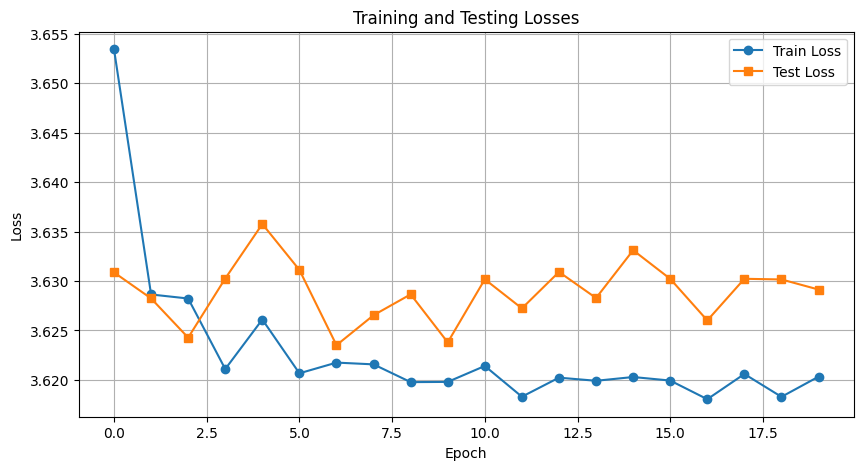

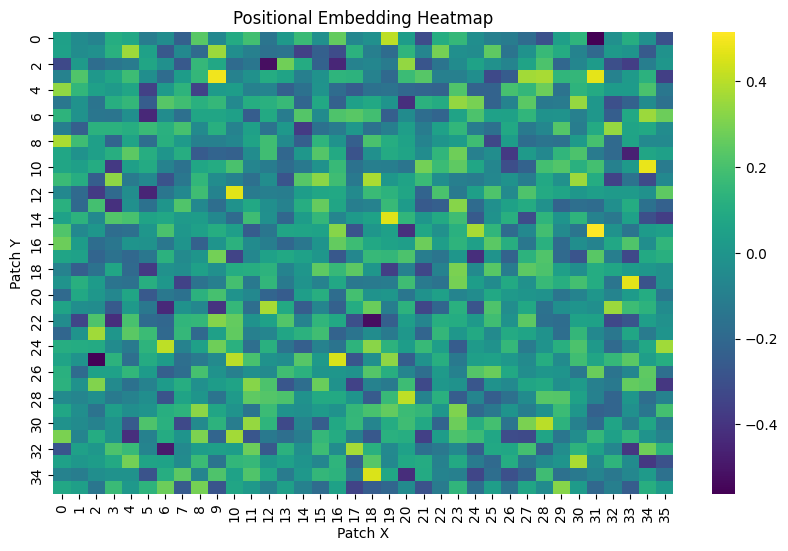

In [24]:
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

device = "cuda"
model = ViT().to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_losses = []
test_losses = []

for epoch in range(20):
    epoch_train_losses = []
    model.train()
    for step, (inputs, labels) in enumerate(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_train_losses.append(loss.item())

    mean_train_loss = np.mean(epoch_train_losses)
    train_losses.append(mean_train_loss)
    print(f">>> Epoch {epoch} train loss: {mean_train_loss}")

    epoch_test_losses = []
    model.eval()
    with torch.no_grad():
        for step, (inputs, labels) in enumerate(test_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            epoch_test_losses.append(loss.item())

    mean_test_loss = np.mean(epoch_test_losses)
    test_losses.append(mean_test_loss)
    print(f">>> Epoch {epoch} test loss: {mean_test_loss}")

# Plot training and testing losses
plt.figure(figsize=(10, 5))
plt.plot(range(20), train_losses, label="Train Loss", marker='o')
plt.plot(range(20), test_losses, label="Test Loss", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Testing Losses")
plt.legend()
plt.grid()
plt.show()

# Extract positional embeddings after training
pos_embedding = model.pos_embedding.detach().cpu().numpy()  # Shape (1, num_patches+1, emb_dim)
pos_embedding = pos_embedding[:, 1:, :]  # Remove the class token (shape: (1, num_patches, emb_dim))

# Reshape to 2D grid (num_patches_height, num_patches_width, emb_dim)
num_patches_per_side = model.height // model.patch_size  # Assuming square image
pos_embedding = pos_embedding.reshape(num_patches_per_side, num_patches_per_side, -1)

# Plot positional embeddings as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pos_embedding.mean(-1), cmap="viridis", annot=False)
plt.xlabel("Patch X")
plt.ylabel("Patch Y")
plt.title("Positional Embedding Heatmap")
plt.show()


In [25]:
inputs, labels = next(iter(test_dataloader))
inputs, labels = inputs.to(device), labels.to(device)
outputs = model(inputs)

print("Predicted classes", outputs.argmax(-1))
print("Actual classes", labels)

Predicted classes tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8], device='cuda:0')
Actual classes tensor([23,  6, 35, 22, 31, 15, 18, 25, 18, 13, 23, 19, 31, 24, 20,  7, 25,  8,
        26, 32, 35,  9, 15, 15, 11, 35, 34,  4, 25, 11, 32, 20],
       device='cuda:0')


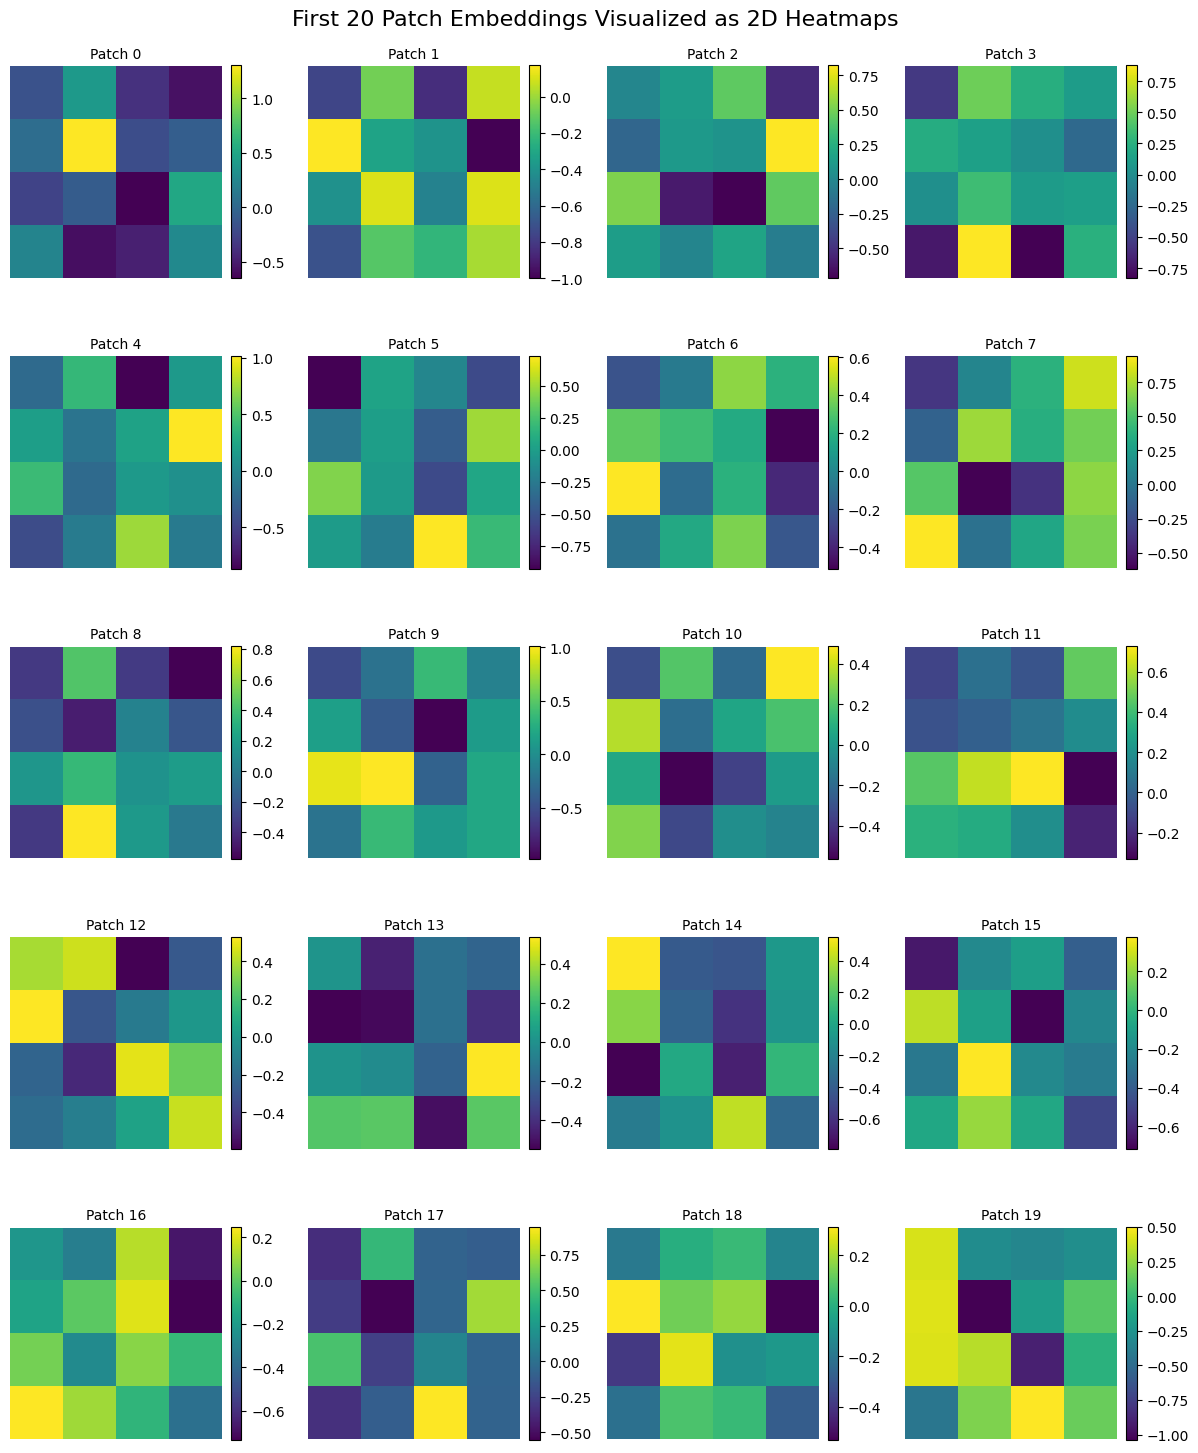

In [31]:
import torch
import matplotlib.pyplot as plt

sample_img = torch.randn(1, 3, 144, 144).to(device)  # (Batch, Channels, Height, Width)

with torch.no_grad():
    patch_embeddings = model.patch_embedding(sample_img)  # Shape: (1, num_patches, emb_dim)

patch_embeddings = patch_embeddings.squeeze(0)  # Shape: (num_patches, emb_dim)

# Get patch-related parameters
num_patches_per_side = model.height // model.patch_size  # Assuming square image
patch_size = model.patch_size
emb_dim = patch_embeddings.shape[-1]

num_patches_to_show = 20
patch_embeddings = patch_embeddings[:num_patches_to_show]  # (20, emb_dim)

# Plot first 20 patch embeddings reshaped into (patch_size, patch_size)
fig, axes = plt.subplots(5, 4, figsize=(12, 15)) 

for i, ax in enumerate(axes.flat):
    if i < num_patches_to_show:
        patch_emb = patch_embeddings[i]  # Shape: (emb_dim,)
        patch_emb = patch_emb.view(patch_size, patch_size, -1).mean(-1)  # Convert to 2D (patch_size, patch_size)

        img = ax.imshow(patch_emb.cpu().numpy(), cmap="viridis")
        ax.set_title(f"Patch {i}", fontsize=10)
        ax.axis("off")

        # Add colorbar
        cbar = fig.colorbar(img, ax=ax, fraction=0.046, pad=0.04)
    else:
        ax.axis("off") 

plt.suptitle("First 20 Patch Embeddings Visualized as 2D Heatmaps", fontsize=16)
plt.tight_layout()
plt.show()
